In [ ]:
pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Download Dataset from Kaggle

In [ ]:
import opendatasets as od

In [ ]:
od.download("https://www.kaggle.com/datasets/salimhammadi07/solar-panel-detection-and-identification")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: tohidtonekaboni
Your Kaggle Key: ··········


100%|██████████| 5.20G/5.20G [00:50<00:00, 111MB/s] 


# 1 ) Import Libraries

In [50]:
import numpy as np
import pandas as pd
import shutil
import tensorflow as tf
from zipfile import ZipFile
import keras.backend as K
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
from PIL import Image

# 2) Data Preparation

In [51]:
def prepare_dataframe(image_path, name):
    """
    Prepares a DataFrame containing image paths and corresponding IDs.

    Args:
    - image_path: The path to the directory containing images.
    - name: The column name for image paths in the DataFrame.

    Returns:
    - df: The prepared DataFrame.
    """
    solar_ids = []
    paths = []
    
    # Walk through the directory and collect image paths and IDs
    for dirname, _, filenames in os.walk(image_path):
        for filename in filenames:
            path = os.path.join(dirname, filename)
            paths.append(path)

            solar_id = filename.split(".")[0]
            solar_ids.append(solar_id)

    d = {"id": solar_ids, name: paths}
    df = pd.DataFrame(data=d)
    df = df.set_index('id')
    return df


def display(display_list):
    """
    Display a list of images.

    Args:
    - display_list: List of images to display.
    """
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()


# Create necessary directories
train_dir = 'train'
train_masks_dir = 'train_masks'

if not os.path.isdir(train_dir):
    os.mkdir(train_dir)

if not os.path.isdir(train_masks_dir):
    os.mkdir(train_masks_dir)

In [52]:
# Copy all images to the image folder and save labels to the label folder with the same name as the corresponding image
root_dir = 'solar-panel-detection-and-identification/PV03'
data_dir = os.path.join(root_dir)

image_root = 'train'
label_root = 'train_masks'

if not os.path.isdir(image_root):
    os.mkdir(image_root)

if not os.path.isdir(label_root):
    os.mkdir(label_root)

images = list()
labels = list()

# Collect image and label paths
for (dirpath, dirnames, filenames) in os.walk(data_dir):
    images += [os.path.join(dirpath, file) for file in filenames]

labels += [i for i in filter(lambda score: '_label.bmp' in score, images)]
images = [i for i in filter(lambda score: '_label.bmp' not in score, images)]

# Resize and save images to the image folder
for img_path in images:
    src_path = img_path
    dst_path = os.path.join(image_root, os.path.basename(img_path))
    img = Image.open(src_path)
    new_img = img.resize((256, 256))
    new_img.save(dst_path[:-4] + '.png', 'png')

# Resize and save labels to the label folder
for label_path in labels:
    src_path = label_path
    file_name = os.path.basename(label_path).replace('_label', '')
    dst_path = os.path.join(label_root, file_name)
    img = Image.open(src_path)
    new_img = img.resize((256, 256))
    new_img.save(dst_path[:-4] + '.png', 'png')


# Print the number of files in the train and train_masks directories
print("Train set:", len(os.listdir(train_dir)))
print("Train masks:", len(os.listdir(train_masks_dir)))

Train set: 2308
Train masks: 2308


In [58]:
df = prepare_dataframe('train', "image_path")
mask_df = prepare_dataframe('train_masks', "mask_path")
df["mask_path"] = mask_df["mask_path"]

In [59]:
df.head()

image_path  \
id                                                   
PV03_348148_1168289  train/PV03_348148_1168289.png   
PV03_343660_1200681  train/PV03_343660_1200681.png   
PV03_325673_1205214  train/PV03_325673_1205214.png   
PV03_326426_1209148  train/PV03_326426_1209148.png   
PV03_321944_1198644  train/PV03_321944_1198644.png   

                                               mask_path  
id                                                        
PV03_348148_1168289  train_masks/PV03_348148_1168289.png  
PV03_343660_1200681  train_masks/PV03_343660_1200681.png  
PV03_325673_1205214  train_masks/PV03_325673_1205214.png  
PV03_326426_1209148  train_masks/PV03_326426_1209148.png  
PV03_321944_1198644  train_masks/PV03_321944_1198644.png

# 3) Create Dataset

In [54]:
img_size = [256, 256]
def data_augmentation(solar_img, mask_img):
    """
    Perform data augmentation on the solar and mask images.

    Args:
    - solar_img: Solar image.
    - mask_img: Mask image.

    Returns:
    - Augmented solar and mask images.
    """
    # Randomly flip the images horizontally
    if tf.random.uniform(()) > 0.5:
        solar_img = tf.image.flip_left_right(solar_img)
        mask_img = tf.image.flip_left_right(mask_img)

    return solar_img, mask_img

In [55]:
def preprocessing(solar_path, mask_path):
    """
    Preprocess the solar and mask images.

    Args:
    - solar_path: Path to the solar image.
    - mask_path: Path to the mask image.

    Returns:
    - Preprocessed solar and mask images.
    """
    solar_img = tf.io.read_file(solar_path)
    solar_img = tf.image.decode_jpeg(solar_img, channels=3)
    solar_img = tf.image.resize(solar_img, img_size)
    solar_img = tf.cast(solar_img, tf.float32) / 255.0

    mask_img = tf.io.read_file(mask_path)
    mask_img = tf.image.decode_jpeg(mask_img, channels=3)
    mask_img = tf.image.resize(mask_img, img_size)
    mask_img = mask_img[:, :, :1]
    mask_img = tf.math.sign(mask_img)

    return solar_img, mask_img

In [61]:
def create_dataset(df, train=False):
    """
    Create a dataset from the DataFrame.

    Args:
    - df: DataFrame containing solar and mask image paths.
    - train: Boolean indicating if it's a training dataset.

    Returns:
    - The created dataset.
    """
    ds = tf.data.Dataset.from_tensor_slices((df["image_path"].values, df["mask_path"].values))
    ds = ds.map(preprocessing, tf.data.AUTOTUNE)

    if train:
        ds = ds.map(data_augmentation, tf.data.AUTOTUNE)

    return ds

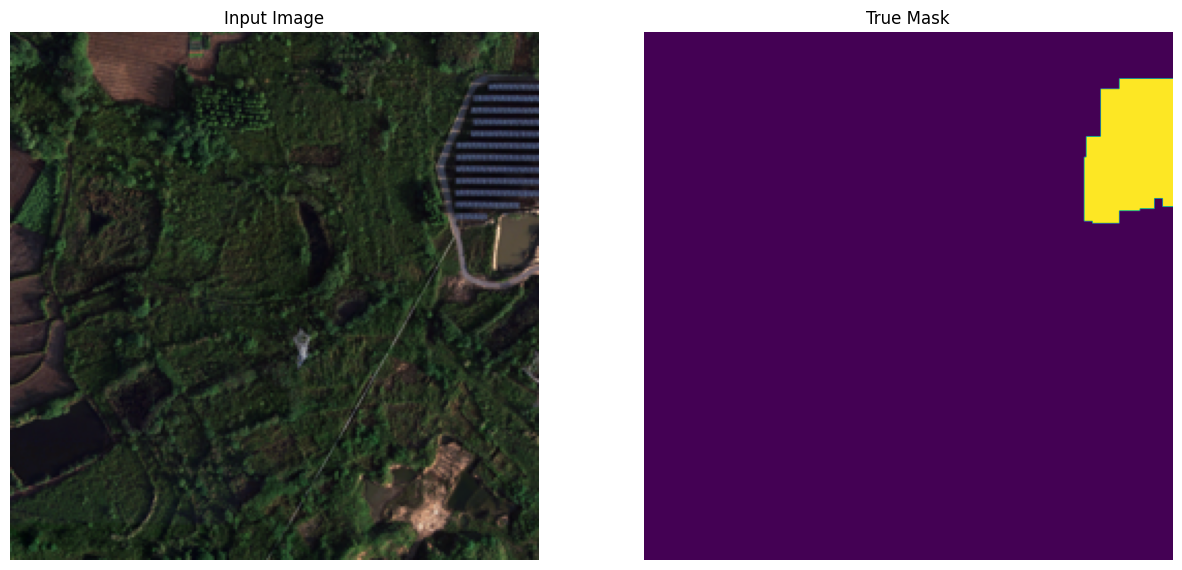

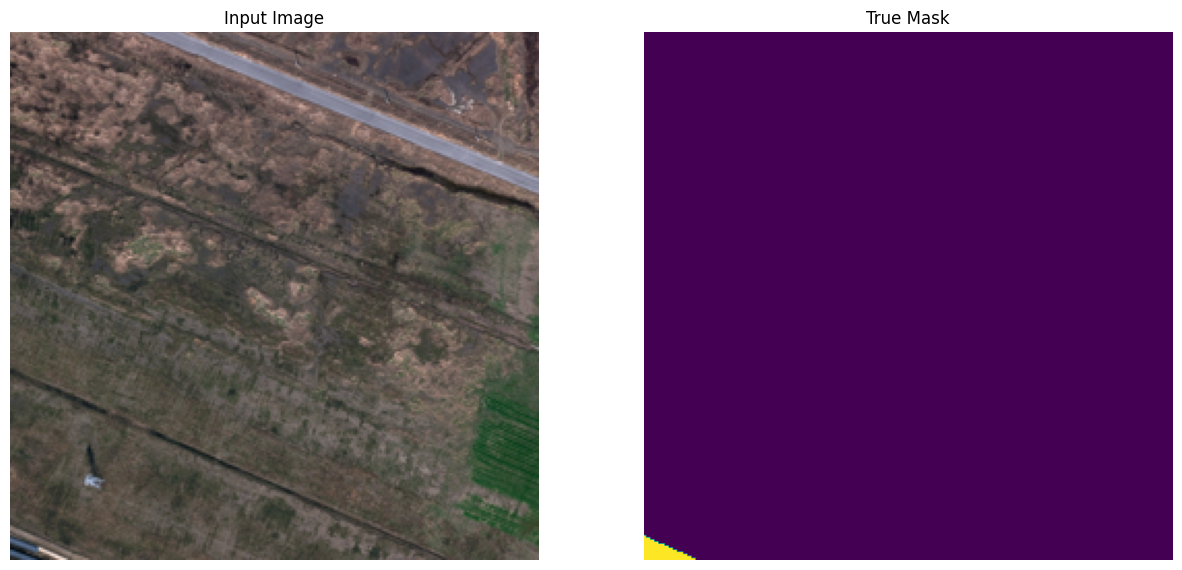

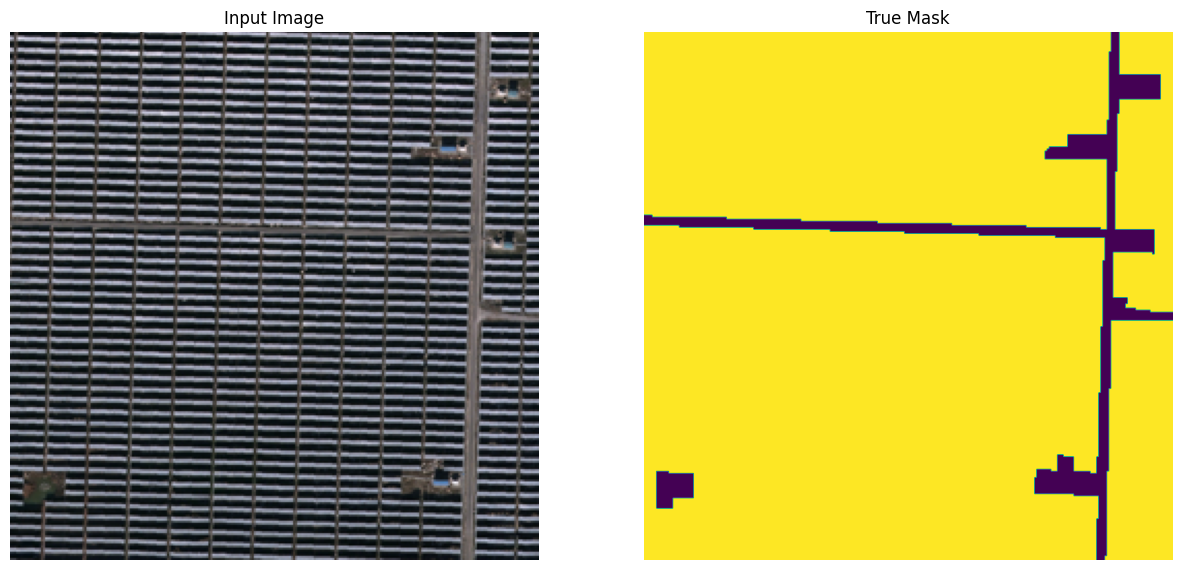

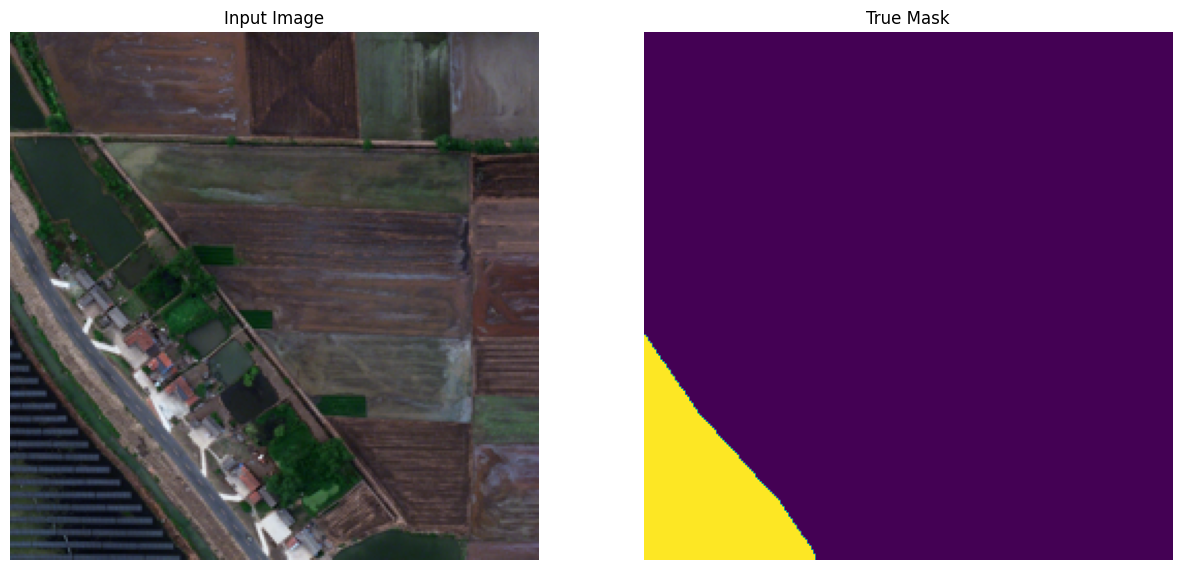

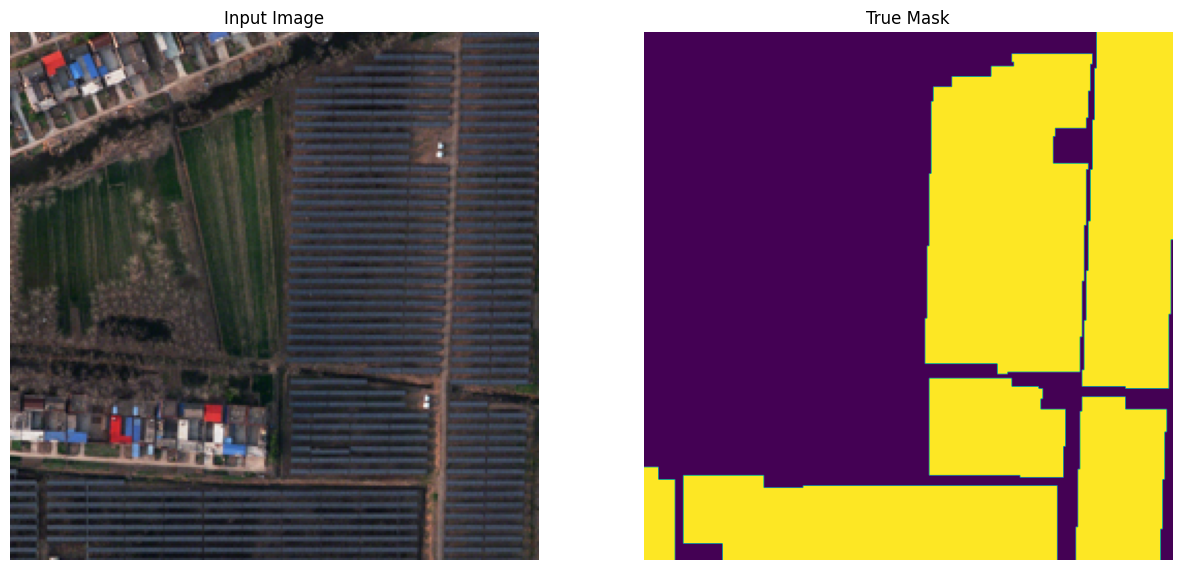

In [62]:
# Split the dataset into train and validation sets
train_df, valid_df = train_test_split(df, random_state=42, test_size=.25)
train = create_dataset(train_df, train=True)
valid = create_dataset(valid_df)


TRAIN_LENGTH = len(train_df)
BATCH_SIZE = 24
BUFFER_SIZE = 1000


# Prepare the datasets for training and validation
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
valid_dataset = valid.batch(BATCH_SIZE)


# Display some sample images from the training dataset
for i, (image, mask) in enumerate(train.take(5)):
    sample_image, sample_mask = image, mask
    display([sample_image, sample_mask])

# 4) Deeplearning Model

In [63]:
# Base model for feature extraction
base_model = tf.keras.applications.MobileNetV2(input_shape=[256, 256, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)
down_stack.trainable = False

In [66]:
from tensorflow.keras.layers import BatchNormalization, Conv2DTranspose, Dropout, ReLU, Concatenate
def upsample(filters, size, norm_type='batchnorm', apply_dropout=False):
    """
    Upsample block for the UNet model.

    Args:
    - filters: Number of filters.
    - size: Size of the filters.
    - norm_type: Type of normalization ('batchnorm' or 'instancenorm').
    - apply_dropout: Whether to apply dropout.

    Returns:
    - Upsample block model.
    """
    initializer = tf.random_normal_initializer(0., 0.02)
    
    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                        padding='same',
                                        kernel_initializer=initializer,
                                        use_bias=False))

    if norm_type.lower() == 'batchnorm':
        result.add(BatchNormalization())
    elif norm_type.lower() == 'instancenorm':
        result.add(InstanceNormalization())

    if apply_dropout:
        result.add(Dropout(0.5))

    result.add(ReLU())

    return result

In [67]:
# Upsampling stack for the UNet model
up_stack = [
    upsample(512, 3),  # 4x4 -> 8x8
    upsample(256, 3),  # 8x8 -> 16x16
    upsample(128, 3),  # 16x16 -> 32x32
    upsample(64, 3),   # 32x32 -> 64x64
]

In [68]:
def unet_model(output_channels):
    """
    Create the UNet model.

    Args:
    - output_channels: Number of output channels.

    Returns:
    - UNet model.
    """
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])

    # Downsampling through the model
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = Concatenate()
        x = concat([x, skip])

    # Last layer of the model
    last = Conv2DTranspose(
        output_channels, 3, strides=2, activation='sigmoid',
        padding='same')  # 64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [69]:
def dice_coef(y_true, y_pred, smooth=1):
    """
    Calculate the dice coefficient.

    Args:
    - y_true: True labels.
    - y_pred: Predicted labels.
    - smooth: Smoothing factor.

    Returns:
    - Dice coefficient.
    """
    intersection = K.sum(y_true * y_pred, axis=[1, 2, 3])
    union = K.sum(y_true, axis=[1, 2, 3]) + K.sum(y_pred, axis=[1, 2, 3])
    return K.mean((2. * intersection + smooth) / (union + smooth), axis=0)

In [70]:
def dice_loss(in_gt, in_pred):
    """
    Calculate the dice loss.

    Args:
    - in_gt: Ground truth labels.
    - in_pred: Predicted labels.

    Returns:
    - Dice loss.
    """
    return 1 - dice_coef(in_gt, in_pred)

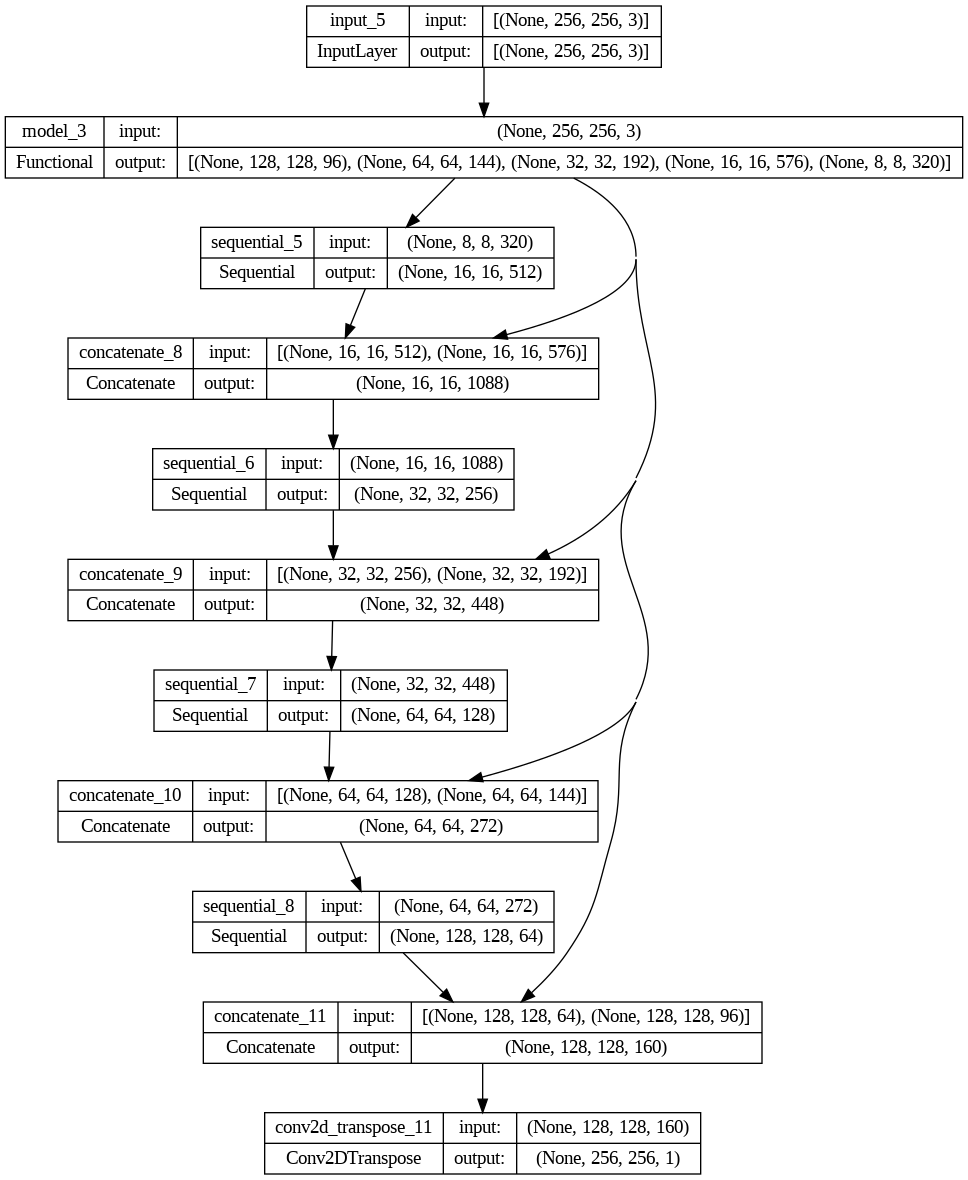

In [71]:
model = unet_model(1)

model.compile(optimizer='adam',
              loss = dice_loss,
              metrics=[dice_coef,'binary_accuracy'])

tf.keras.utils.plot_model(model, show_shapes=True)


# 5) Training

In [72]:
# Visualize the input images, true masks, and predicted masks
def visualize(display_list):
    """
    Visualize the input images, true masks, and predicted masks.

    Args:
    - display_list: List of images to display.

    Returns:
    - None
    """
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

In [73]:
# Show predictions for a sample image and mask
def show_predictions(sample_image, sample_mask):
    """
    Show predictions for a sample image and mask.

    Args:
    - sample_image: Sample input image.
    - sample_mask: Corresponding true mask.

    Returns:
    - None
    """
    pred_mask = model.predict(sample_image[tf.newaxis, ...])
    pred_mask = pred_mask.reshape(img_size[0], img_size[1], 1)
    visualize([sample_image, sample_mask, pred_mask])


In [74]:
# Display the summary of the model
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_3 (Functional)           [(None, 128, 128, 9  1841984     ['input_5[0][0]']                
                                6),                                                               
                                 (None, 64, 64, 144                                               
                                ),                                                                
                                 (None, 32, 32, 192                                         

Epoch 1/30
72/72 [==============================] - 27s 221ms/step - loss: 0.3895 - dice_coef: 0.6105 - binary_accuracy: 0.7951 - val_loss: 0.1946 - val_dice_coef: 0.8045 - val_binary_accuracy: 0.9523
Epoch 2/30
72/72 [==============================] - 16s 205ms/step - loss: 0.1854 - dice_coef: 0.8149 - binary_accuracy: 0.9546 - val_loss: 0.1728 - val_dice_coef: 0.8279 - val_binary_accuracy: 0.9585
Epoch 3/30
72/72 [==============================] - 22s 311ms/step - loss: 0.1663 - dice_coef: 0.8350 - binary_accuracy: 0.9571 - val_loss: 0.1544 - val_dice_coef: 0.8473 - val_binary_accuracy: 0.9607
Epoch 4/30
1/1 [==============================] - 1s 861ms/step


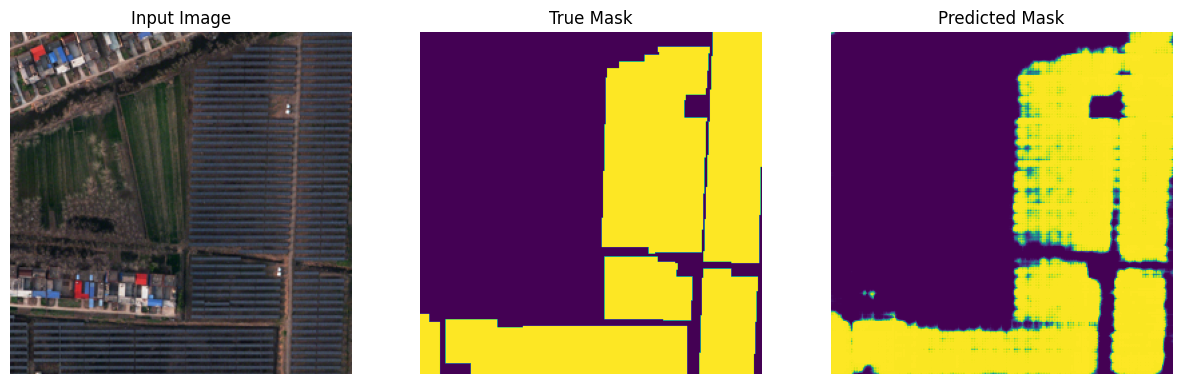

Epoch 5/30
72/72 [==============================] - 14s 197ms/step - loss: 0.1541 - dice_coef: 0.8459 - binary_accuracy: 0.9582 - val_loss: 0.1520 - val_dice_coef: 0.8496 - val_binary_accuracy: 0.9612
Epoch 6/30
72/72 [==============================] - 14s 201ms/step - loss: 0.1415 - dice_coef: 0.8584 - binary_accuracy: 0.9609 - val_loss: 0.1489 - val_dice_coef: 0.8496 - val_binary_accuracy: 0.9635
Epoch 7/30
72/72 [==============================] - 15s 202ms/step - loss: 0.1360 - dice_coef: 0.8630 - binary_accuracy: 0.9621 - val_loss: 0.1488 - val_dice_coef: 0.8488 - val_binary_accuracy: 0.9635
Epoch 8/30
72/72 [==============================] - 14s 199ms/step - loss: 0.1327 - dice_coef: 0.8658 - binary_accuracy: 0.9610 - val_loss: 0.1393 - val_dice_coef: 0.8610 - val_binary_accuracy: 0.9652
Epoch 9/30
1/1 [==============================] - 0s 24ms/step


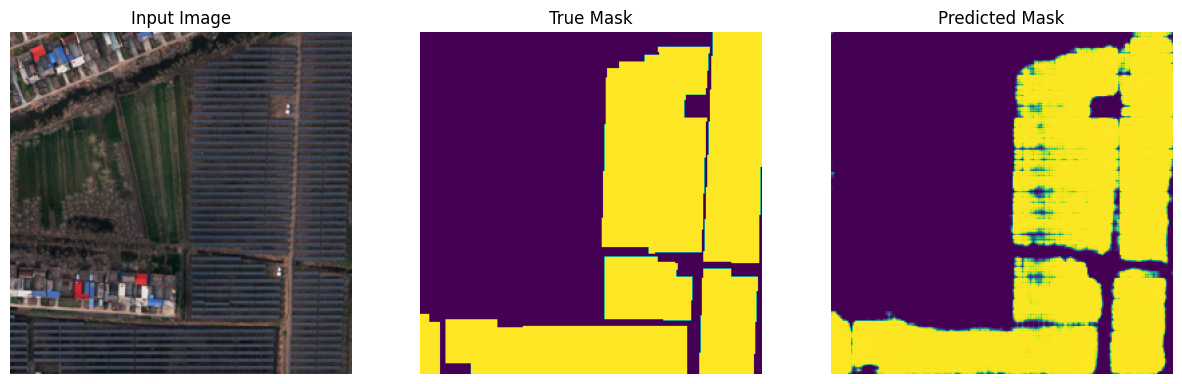

Epoch 10/30
72/72 [==============================] - 14s 188ms/step - loss: 0.1300 - dice_coef: 0.8691 - binary_accuracy: 0.9623 - val_loss: 0.1374 - val_dice_coef: 0.8599 - val_binary_accuracy: 0.9656
Epoch 11/30
72/72 [==============================] - 14s 198ms/step - loss: 0.1213 - dice_coef: 0.8763 - binary_accuracy: 0.9632 - val_loss: 0.1359 - val_dice_coef: 0.8642 - val_binary_accuracy: 0.9667
Epoch 12/30
72/72 [==============================] - 14s 189ms/step - loss: 0.1197 - dice_coef: 0.8809 - binary_accuracy: 0.9646 - val_loss: 0.1358 - val_dice_coef: 0.8644 - val_binary_accuracy: 0.9674
Epoch 13/30
72/72 [==============================] - 14s 190ms/step - loss: 0.1169 - dice_coef: 0.8802 - binary_accuracy: 0.9655 - val_loss: 0.1346 - val_dice_coef: 0.8665 - val_binary_accuracy: 0.9673
Epoch 14/30
1/1 [==============================] - 0s 50ms/step


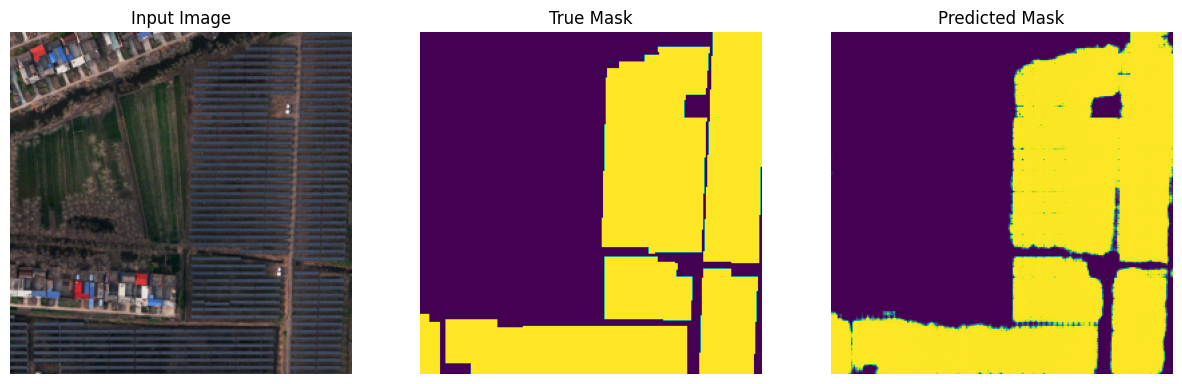

Epoch 15/30
72/72 [==============================] - 17s 234ms/step - loss: 0.1095 - dice_coef: 0.8915 - binary_accuracy: 0.9652 - val_loss: 0.1369 - val_dice_coef: 0.8634 - val_binary_accuracy: 0.9660
Epoch 16/30
72/72 [==============================] - 14s 197ms/step - loss: 0.1040 - dice_coef: 0.8964 - binary_accuracy: 0.9669 - val_loss: 0.1433 - val_dice_coef: 0.8534 - val_binary_accuracy: 0.9658
Epoch 17/30
72/72 [==============================] - 14s 200ms/step - loss: 0.1000 - dice_coef: 0.9006 - binary_accuracy: 0.9687 - val_loss: 0.1396 - val_dice_coef: 0.8605 - val_binary_accuracy: 0.9685


In [77]:
# Early stopping callback to stop training if no improvement is observed
early_stop = tf.keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True)

# Custom callback to display predictions during training
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        if (epoch + 1) % 5 == 0:
            show_predictions(sample_image, sample_mask)

EPOCHS = 30
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

# Train the model
model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_data=valid_dataset,
                          callbacks=[DisplayCallback(), early_stop])

1/1 [==============================] - 0s 27ms/step


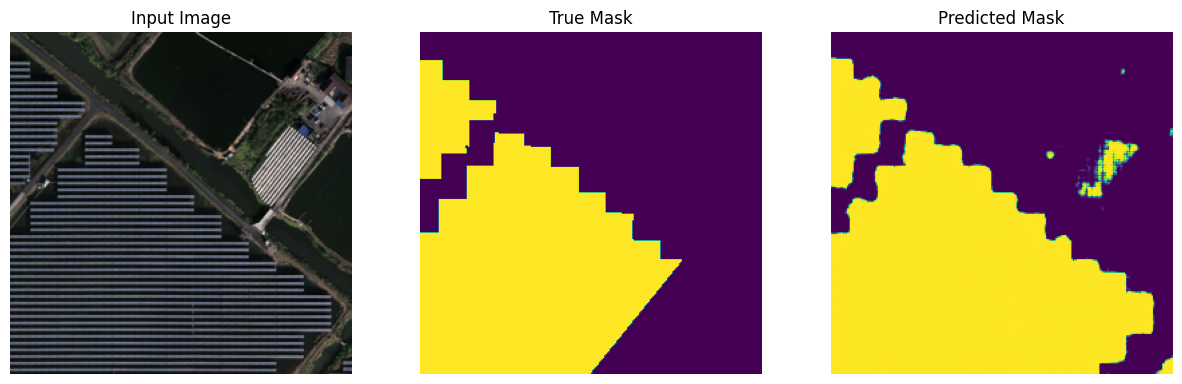

1/1 [==============================] - 0s 27ms/step


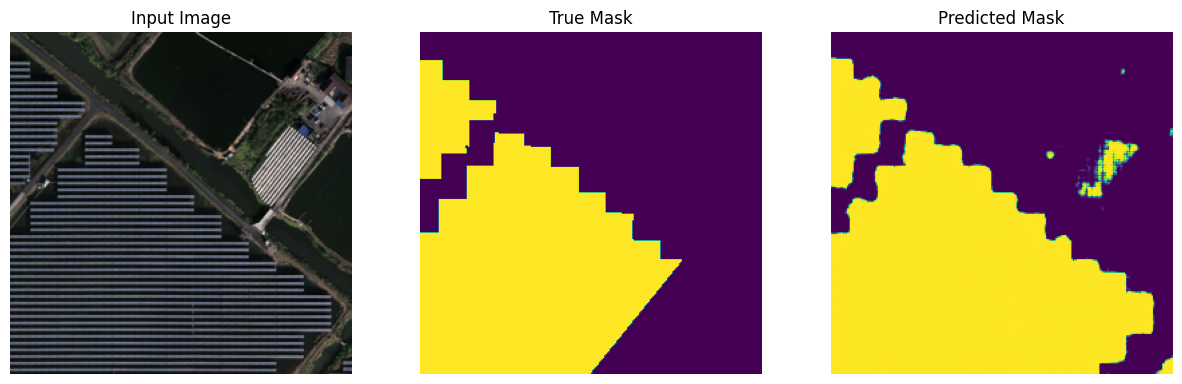

1/1 [==============================] - 0s 44ms/step


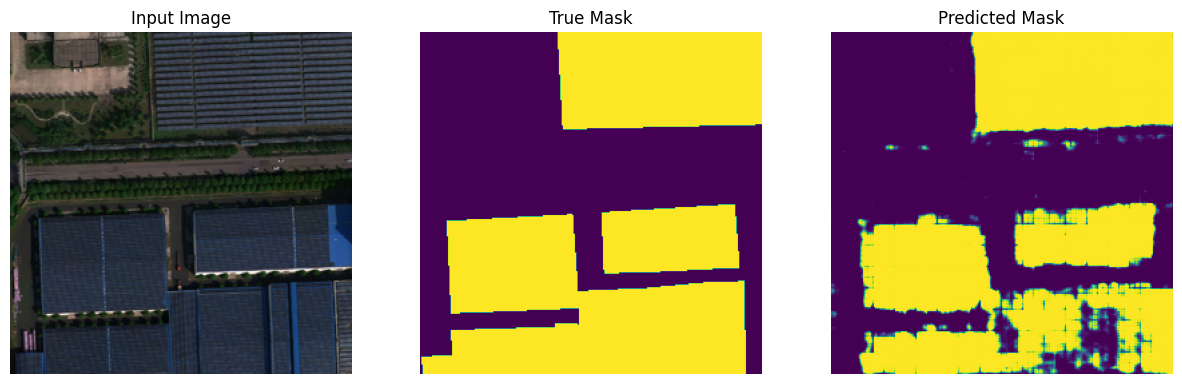

1/1 [==============================] - 0s 25ms/step


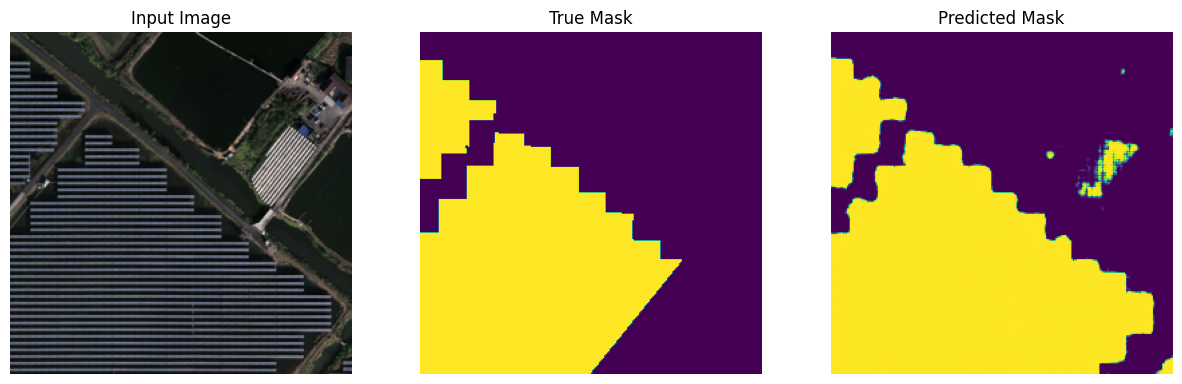

1/1 [==============================] - 0s 41ms/step


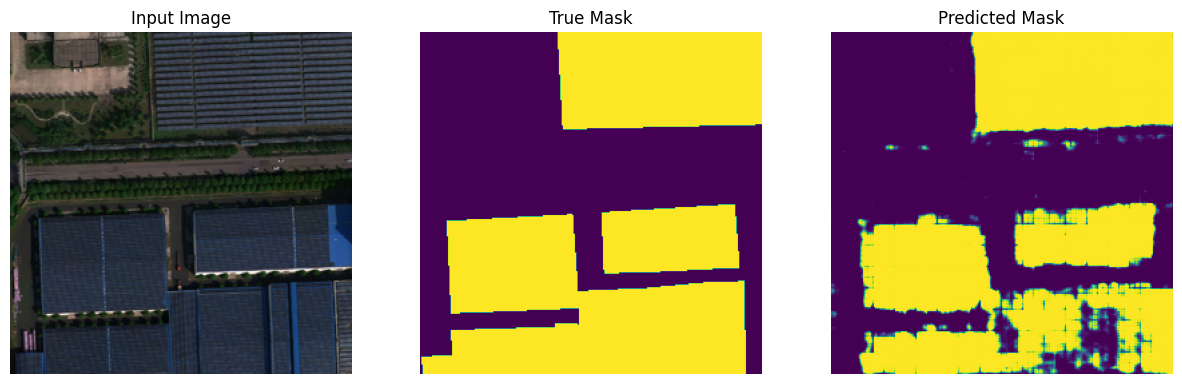

1/1 [==============================] - 0s 49ms/step


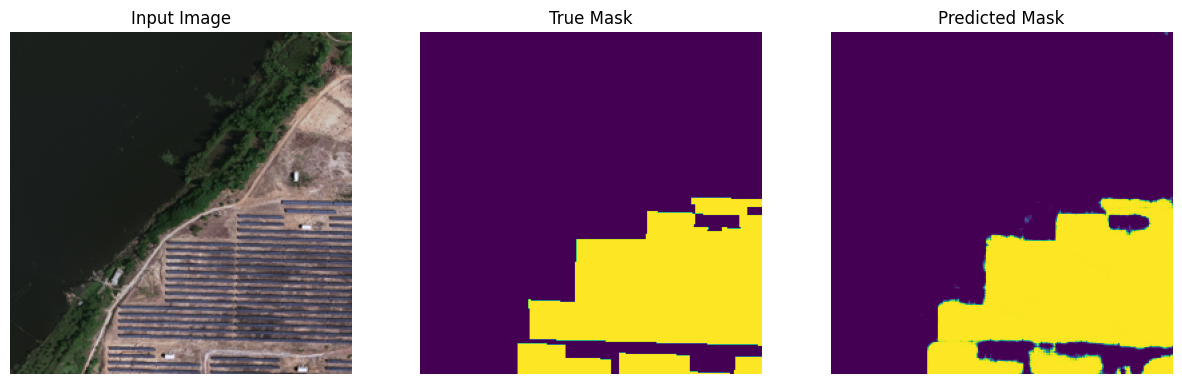

1/1 [==============================] - 0s 34ms/step


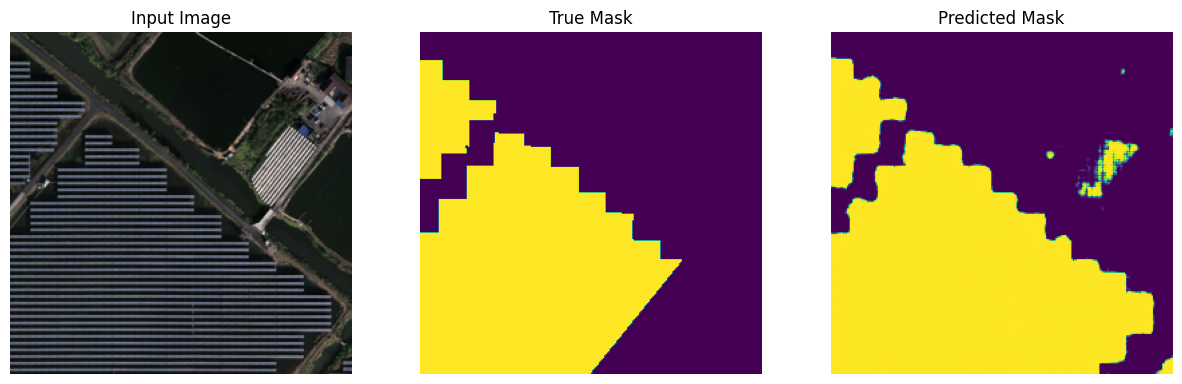

1/1 [==============================] - 0s 41ms/step


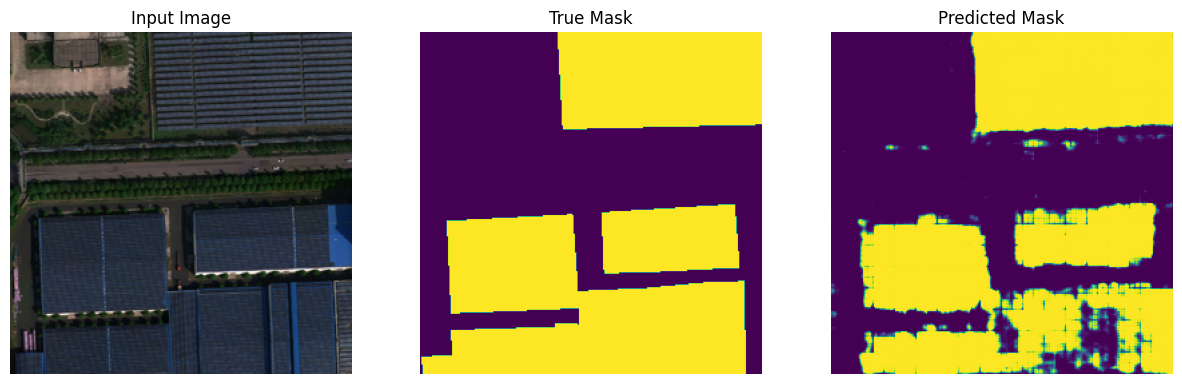

1/1 [==============================] - 0s 34ms/step


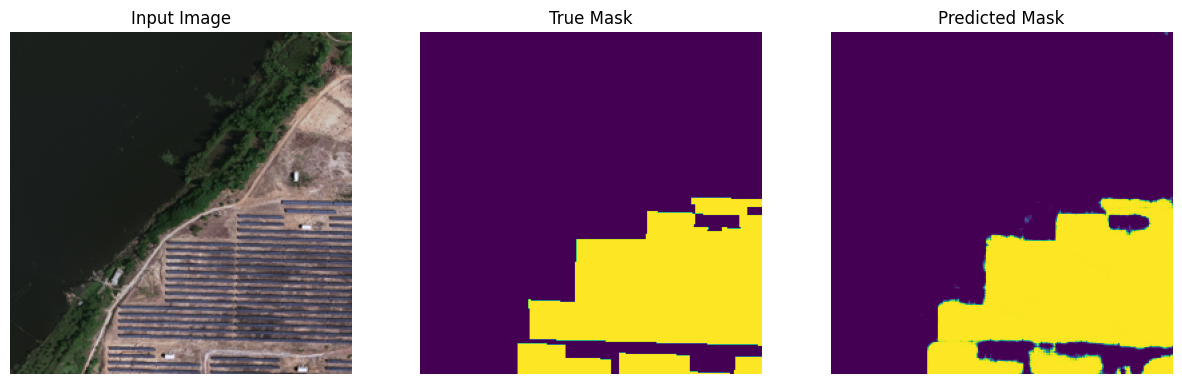

1/1 [==============================] - 0s 62ms/step


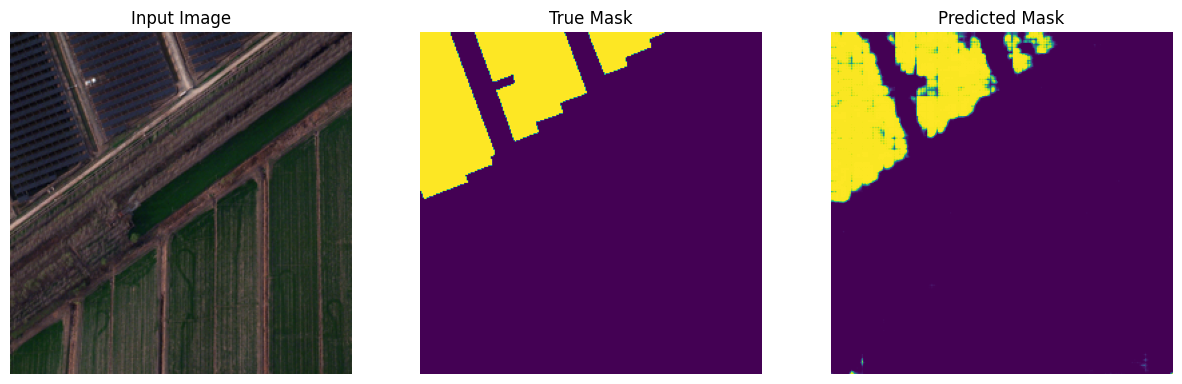

In [78]:
for i in range(5):
    for image, mask in valid.take(i):
        sample_image, sample_mask = image, mask
        show_predictions(sample_image, sample_mask)

In [79]:
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk
